
In this notebook, we will try the process of implementing RNN with Keras in order to classify text sentences.

I.   **Firstly**, we'll import useful packages.

II.   **Then**, we'll load the data and create a word embedding matrix using Glove.

III.  **We'll try a simple RNN model** and then we will evaluate its performances.

IV. Finally, we'll use techniques to increase our model's accuracy.

**Task 1:** Setting Fre GPU in this Google Colab notebook.

## Mounting Google Drive locally
**Task 2:** Mount the Google Driver into the Google Colab Driver.


In [ ]:
## TYPE YOUR CODE for task 2 here:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Text_Classification
%ls

# I. Let import all useful packages.

In [ ]:
!pip install tensorflow_addons

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import tensorflow.keras
import datetime
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import backend as K
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
import tensorflow_addons as tfa

from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import keras.models
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_preprocessing import sequence
import tensorflow as tf
import datetime, os
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import sklearn.metrics as metrics

**Task 3**: Copy the dataset from Google Drive into Colab

# II. Load the data.

## About dataset.
An invalid question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is invalid:

* Has a non-neutral tone.
* Is disparaging or inflammatory.
* Isn't grounded in reality.
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The data includes the question that was asked, and whether it was identified as invalid (target = 1). 

**Task 4**: Load the dataset.
* Load the data from CSV file.
* Remove all the rows with NA values.
* Split the data into 3 set: Training set, validation set and test set (0.9/0.05/0.05, random_seed = 9) with a same ratio of data number beween each class.
* Print out these dataset's description.




In [ ]:
# Processing Imbalance Data
#Load Data from Source
'''
Nhằm cải thiện độ chính xác mô hình, ngoài các yêu cầu cơ bản của mô hình 
ta thêm và một bước nữa đó là xử 
lí dữ liệu mất cân bằng
'''
data=pd.read_csv("train.csv")
input=data["question_text"]
label=data["target"]

In [ ]:
input.shape, label.shape

In [ ]:
# Check Imbalance Data
label.value_counts() # Dữ liệu bị chênh lệch giữa 2 biến 1 và 0

In [ ]:
input=input.values.reshape(-1,1)
label=label.values.reshape(-1,1)
input.shape, label.shape

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(
    sampling_strategy='majority',  # samples only the majority class
    random_state=0,  # for reproducibility
    replacement=True # if it should resample with replacement
)  
X_resampled, y_resampled = rus.fit_resample(input,label)

In [ ]:
# print shape of output Data
X_resampled.shape, y_resampled.shape

In [ ]:
data_process=pd.DataFrame()
data_process["question_text"]=X_resampled.reshape(-1,)
data_process["target"]=y_resampled

In [ ]:
data_process["question_text"]=X_resampled.reshape(-1,)
data_process["target"]=y_resampled

In [ ]:
def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set and test_set(0.95/0.05/0.05) without NA values.
    '''
    
    ## TYPE YOUR CODE for task 4 here:
    data=data_link
    data = data.rename(columns={'target': 'label'})
    train, val_test= train_test_split(data[["question_text","label"]],stratify=data["label"] ,test_size = 0.05,  random_state = 0)
    validation, test=train_test_split(val_test[["question_text","label"]],stratify=val_test["label"] , test_size = 0.5,  random_state = 0)
    return train, validation, test

train_set, validation_set, test_set = load_data(data_process)
print(train_set['label'].describe())
print(validation_set['label'].describe())
print(test_set['label'].describe())

# Encoding text data.
Let declare some fundamental parameters first:

In [ ]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 50 # max number of words in a question to use

**Task 5:** Encode the dataset using Tokenizer and one-hot encoding vector.
* Encode the text (question_text column) by turning each question text into a list of word indexes using [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) with **max_features** and all the text sentences from the training and the validation set. 
* Turn each list of word indexes into an equal length - **max_len** (with truncation or padding as needed) using [pad_sequences](https://keras.io/preprocessing/sequence/).
* Encode the label (label column) using [to_categorical](https://keras.io/utils/) function on Keras.

In [ ]:
data=pd.read_csv("train.csv")

In [16]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    ## TYPE YOUR CODE for task 5 here:
    tokenizer = Tokenizer(num_words=max_features)
    data=pd.concat([train_set, validation_set])
    tokenizer.fit_on_texts(data["question_text"])

    train_token =tokenizer.texts_to_sequences(train_set["question_text"])
    val_token   =tokenizer.texts_to_sequences(validation_set["question_text"])    
    test_token  =tokenizer.texts_to_sequences(test_set["question_text"])

    X_tr=pad_sequences(train_token, maxlen= max_len)
    X_va=pad_sequences(val_token, maxlen= max_len)   
    # X_te=test_set["question_text"] 
    X_te=pad_sequences(test_token, maxlen= max_len)  

    y_tr,y_va,y_te=train_set["label"], validation_set["label"], test_set["label"]
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer   

(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)

**Task 6**: Create word embedding matrix.
* Firstly, write a function to [load the GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Then, create a word embedding matrix using GloVe dictionary with these parameters:
    - Word embedding matrix shape: (Number of word, embed_size).
    - Embed size: 50.
    - Number of words: The minimum of (max_features, len(word_index)), while word_index is the dictionary of word which contains in tokenizer.
    - If a word occurs in GloVe dictionary, we should take its initialization value as in GloVe dictionary. Otherwise, take a normal random value with mean and std as mean and std of GloVe dictionary value.
    



In [17]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    ## TYPE YOUR CODE for task 6 here:
    embeddings_index = {}
    with open(GloVe_link) as f:
        for line in f:
            values = line.split()
            word = values[0]            
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return  embeddings_index        
GloVe_link = 'glove.6B.50d.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)

In [18]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 50 # max number of words in a question to use

In [19]:
# min(max_features,line)

In [20]:
# Calculate mean and std of Glove
values=[]
data_value_of_golve=pd.DataFrame(columns=["values"])   
for i in GloVe_dict.values():
    values.append(i)
value=np.array(values)
data_value_of_golve["values"]=GloVe_dict.values()
mean=data_value_of_golve["values"].mean()
array_std=np.array(data_value_of_golve["values"].values)
array_std=array_std.reshape(-1,50)
std=array_std.std()

def initialization_vector(mean,std):
    """
    If a word occurs in GloVe dictionary, we should take its 
    initialization value as in GloVe dictionary.
    Otherwise, take a normal random value with mean and std 
    as mean and std of GloVe dictionary value.
    """
    initialization_vector = np.random.normal(loc=mean, scale=std, size=50)
    return initialization_vector

def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer từ tập huấn luyện và tập kiểm định, số lượng đặc trưng tối đa.
    output: Word embedding matrix.
    '''
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embed_size))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = GloVe_dict.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i]=initialization_vector(mean,std)
    return embedding_matrix

embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

III. Modelling
There are some steps we need to finish:
Build the model.

Compile the model.

Train / fit the data to the model.

Evaluate the model on the testing set.

## Build the model
**Task 7:** We can build an easy model composed of different layers such as:
* [Embedding](https://keras.io/layers/embeddings/) layer with max_features, embed_size and embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/nlp/bidirectional_lstm_imdb/?fbclid=IwAR3fEd6aWyeIDEhZSspjtCRiP0c0Jnz5-XdnUHQYwX8Tp8k9Ni4I8Q5tP9o) with number of hidden state = 50, dropout_rate = 0.1 and recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense with number of unit = 50, activation = 'relu'.
* Dropout with rate = 0.1.
* Final dense with number of unit = number of class, activation = 'sigmoid'.

In [21]:
def create_model(max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    ## TYPE YOUR CODE for task 7 here:
    model = keras.Sequential()
    embedding_layer= layers.Embedding(
                          input_dim=embedding_matrix.shape[0], # thiết lập shape đầu vào
                          output_dim=embed_size, # thiết lập kích thước của vectơ embedding
                          embeddings_initializer="uniform", # mặc định, khởi tại ngẫu nhiên
                          weights=[embedding_matrix],
                          input_length=max_len, # mỗi đầu vào dài bao nhiêu
                          # trainable=False,
                          name="embedding") 
    
    # text_vectorizer = TextVectorization(max_tokens=None, # có bao nhiêu từ trong từ vựng (toàn bộ các từ khác nhau trong text)
    #                                 standardize="lower_and_strip_punctuation", # cách xử lý text
    #                                 split="whitespace", # cách phân chia token
    #                                 ngrams=None, # có tạo nhóm n-từ không?
    #                                 output_mode="int", # cách ánh xạ token thành số
    #                                 output_sequence_length=None)
    
    model.add(layers.Input(shape=(50,)))
    # model.add(text_vectorizer)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(50,return_sequences=True)))
    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(50,activation="relu"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1,activation="sigmoid"))   
    
    return model

model = create_model(max_len, max_features, embed_size)

**Task 8:** Compile the model and setup the callback. Then print out the model summary.
* [Compile](https://keras.io/models/model/#compile) the model with Adam Optimizaer, lr = 1e-2, suitable loss for binary classification problem and ["F1-score"](https://github.com/tensorflow/addons/issues/825) as metric.
* Print out the model summary.

In [22]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [28]:
def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['acc',f1_metric])
    return model

model = optimize(model)

**Task 9**: Setup callback.
* Create the [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to save the logs.
* Create the [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) to save the checkpoint with the best accuracy after each epoch.
* Create the [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback with factor=0.3, patience=1 and "Validation F1-score" monitor.
* Create the [early stopping callback](https://keras.io/callbacks/#earlystopping) with patience=7, mode = 'max' and "Validation F1-score" monitor.



In [29]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Checkpoint name, logs name tốt nhất.
    Return: 
        Callback list có chứa tensorboard callback và checkpoint callback.
    '''
    #Tensorboard
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback=tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    tensorboard_callback=tf.keras.callbacks.TensorBoard(logs_name, histogram_freq=1)
    #Early_Stopping
    early_stopping = EarlyStopping(monitor = 'val_f1_metric',
                               patience = 7,
                               mode = 'max',
                               restore_best_weights = True)

    # Save the model with the minimum validation loss
    checkpoint = ModelCheckpoint(checkpoint_name,monitor = 'val_f1_metric',verbose = 1,mode = 'max', save_best_only = True)

    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_f1_metric',factor = 0.3,patience = 1)

    callbacks_list=[tensorboard_callback,checkpoint,reduce_lr,early_stopping]                              
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

**Task 10:** Train the model.

* Train the model with 20 epochs with batch_size = 4096.
* Return the model with best-checkpoint weights.

*Hint*: Fit the model first, then reload the model (load_model function) with best-checkpoint weights.

In [30]:
def train_model(model, callbacks_list):
    '''
    Input: 
        Model and callback list,
    Return: 
        Model with best-checkpoint weights.
    '''
    ## TYPE YOUR CODE for task 10 here:
    model.fit(X_tr,
              y_tr,              
              epochs=20,
              batch_size = 4096,
              validation_data=(X_va,y_va),
              callbacks=callbacks_list
              )
    return model

model = train_model(model, callbacks_list)


Epoch 1/20
37/38 [============================>.] - ETA: 0s - loss: 0.4262 - acc: 0.7929 - f1_metric: 0.7884
Epoch 1: val_f1_metric improved from -inf to 0.89301, saving model to weights.best.hdf5
38/38 [==============================] - 15s 170ms/step - loss: 0.4243 - acc: 0.7942 - f1_metric: 0.7912 - val_loss: 0.2845 - val_acc: 0.8901 - val_f1_metric: 0.8930 - lr: 0.0100
Epoch 2/20
37/38 [============================>.] - ETA: 0s - loss: 0.2585 - acc: 0.9013 - f1_metric: 0.9023
Epoch 2: val_f1_metric improved from 0.89301 to 0.90252, saving model to weights.best.hdf5
38/38 [==============================] - 3s 83ms/step - loss: 0.2582 - acc: 0.9015 - f1_metric: 0.9026 - val_loss: 0.2665 - val_acc: 0.9005 - val_f1_metric: 0.9025 - lr: 0.0100
Epoch 3/20
37/38 [============================>.] - ETA: 0s - loss: 0.2247 - acc: 0.9167 - f1_metric: 0.9175
Epoch 3: val_f1_metric improved from 0.90252 to 0.90592, saving model to weights.best.hdf5
38/38 [==============================] - 3s 82m

**Task 11:** Show the tensorboard in the notebook.

In [31]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Classification_Toxic_Comment" \
  --description "The Last Training" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=pIpCQ4nFUum4bF9XtCjTOOLhrrtZC2&prompt=consent&access_type=offli

**Task 12:** Prediction on test set.

* Complete the get_prediction_classes function.
* Print out the precision, recall and F1 score.

In [32]:
def get_prediction_classes(model, X, y):
    ## TYPE YOUR CODE for task 13 here:
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    predictions=model.predict(X)
    predictions=np.around(predictions,0)
    groundtruths=y.values
    groundtruths=groundtruths.reshape(-1,1)
    return predictions, groundtruths 

test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)
print(precision_score(test_predictions, test_groundtruths))
print(recall_score(test_predictions, test_groundtruths))
print(f1_score(test_predictions, test_groundtruths))

0.9193069306930693
0.8872431915910177
0.9029905178701678


**Task 13:** Perform the predicted result on test set using confusion matrix. Remember to show the class name in the confusion matrix.

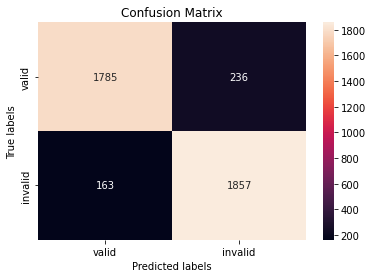

In [33]:
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## TYPE YOUR CODE for task 13 here:    
    cf=metrics.confusion_matrix(groundtruth,predictions)
    ax= plot.subplot()
    sns.heatmap(cf, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names)
class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)